<a href="https://colab.research.google.com/github/LUUTHIENXUAN/DepthEstimation_Unet_Densenet/blob/main/Monocular_depth_estimation_TransUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monocular depth estimation

**Author:** [LUUTHIENXUAN](https://www.linkedin.com/in/thienxuanluu/)<br>
**Date created:** 2022/01/10<br>
**Last modified:** 2022/01/10<br>
**Description:** Implement a depth estimation model with a transunet.


## Introduction

_Depth estimation_ is a crucial step towards inferring scene geometry from 2D images.
The goal in _monocular depth estimation_ is to predict the depth value of each pixel or
inferring depth information, given only a single RGB image as input.
This example will show an approach to build a depth estimation model with a convnet
and simple loss functions.

![depth](https://paperswithcode.com/media/thumbnails/task/task-0000000605-d9849a91.jpg)

## Setup

In [ ]:
import os
import sys

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

## Downloading the dataset

We will be using the dataset **DIODE: A Dense Indoor and Outdoor Depth Dataset**  for this
tutorial. However, we use the validation set generating training and evaluation subsets
for our model. The reason we use the validation set rather than the training set of the original dataset is because
the training set consists of 81GB of data, which is challenging to download compared
to the validation set which is only 2.6GB.
Other datasets that you could use are
**[NYU-v2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)**
and **[KITTI](http://www.cvlibs.net/datasets/kitti/)**.

The dataset consists of RGB images, depth maps, depth validity masks and surface normal maps. Their formats are as follows:

RGB images (*.png): RGB images with a resolution of 1024 × 768.

Depth maps (*_depth.npy): Depth ground truth with the same resolution as the images.

Depth masks (*_depth_mask.npy): Binary depth validity masks where 1 indicates valid sensor returns and 0 otherwise.

In [ ]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
#https://www.tensorflow.org/datasets/add_dataset#tldr
class DiodeDepth(tfds.core.GeneratorBasedBuilder):
    """Short description of my dataset."""

    VERSION = tfds.core.Version('1.0.0')
    RELEASE_NOTES = {
      '1.0.0': 'Initial release.',
    }

    def __init__(self):
      """
      Initialization
      """
      self.mode = "val"

    def _info(self)-> tfds.core.DatasetInfo:
      """Dataset metadata (homepage, citation,...)."""
      return tfds.core.DatasetInfo(
          builder=self,
          # This is the description that will appear on the datasets page.
          description=("This is the dataset for DIODE(Dense Indoor/Outdoor DEpth). It contains images as .png, depth information per pixel as .npy, and a depth mask as .npy. The images are kept at their original dimensions(all are 768x1024)."),
          # tfds.features.FeatureConnectors
          #RGB images (*.png): RGB images with a resolution of 1024 × 768.
          #Depth maps (*_depth.npy): Depth ground truth with the same resolution as the images.
          #Depth masks (*_depth_mask.npy): Binary depth validity masks where 1 indicates valid sensor returns and 0 otherwise.
          features=tfds.features.FeaturesDict({
                "image": tfds.features.Image(encoding_format="png"),
                "depth": tfds.features.Image(shape=(768,1024,1)),
                "depth_mask": tfds.features.Image(shape=(768,1024,1)),
          }),
          # If there's a common (input, target) tuple from the features,
          # specify them here. They'll be used if as_supervised=True in
          # builder.as_dataset.
          supervised_keys=("image", "depth"),
          # Homepage of the dataset for documentation
          homepage="https://diode-dataset.org/",
          # Bibtex citation for the dataset
          citation= r"""@article{diode_dataset,
                    Title={{DIODE}: {A} {D}ense {I}ndoor and {O}utdoor {DE}pth {D}ataset},
                    Author={Igor Vasiljevic and Nick Kolkin and Shanyi Zhang and Ruotian Luo and 
                            Haochen Wang and Falcon Z. Dai and Andrea F. Daniele and Mohammadreza Mostajabi and 
                            Steven Basart and Matthew R. Walter and Gregory Shakhnarovich},
                    Sensor Performance:
                    –  Return Density: 99.6% (indoor) / 66.9% (outdoor) 
                    –  Depth Precision: ±1 mm 
                    –  Angular Resolution: 0.009°
                    –  Max Range: 350 m
                    –  Min Range: 0.6 m
                    Diversity:
                    –  Time: both daytime and night, several months (summer, fall, winter).
                    –  Location: data collection in several cities, various indoor/outdoor scene and background layout.
                    –  Dataset Curation: manually selected image crops with diverse objects.                   
                    Year = {2019}
                    Journal={CoRR},
                    Volume={abs/1908.00463},
                    Year = {2019},
                    Url={http://arxiv.org/abs/1908.00463}
                    }""",
        )

    def _split_generators(self, dl_manager: tfds.download.DownloadManager):
      """Download the data and define splits."""

      if self.mode == "all":
        
        self.extracted_path = dl_manager.download_and_extract({
              'train': 'http://diode-dataset.s3.amazonaws.com/train.tar.gz',
              'validation': 'http://diode-dataset.s3.amazonaws.com/val.tar.gz'
          }) 
        
        # Specify the splits
        return [
              tfds.core.SplitGenerator(
                  name=tfds.Split.TRAIN,
                  gen_kwargs={
                      "data_directory": self.extracted_path['train'],
                      "indoors_outdoor_all": "all"
                  },
              ),
              tfds.core.SplitGenerator(
                  name=tfds.Split.VALIDATION,
                  gen_kwargs={
                      "data_directory": self.extracted_path['validation'],
                      "indoors_outdoor_all": "all"
                  },
              ),
          ]
      
      if self.mode == "train":
        self.extracted_path = dl_manager.download_and_extract({
              'train': 'http://diode-dataset.s3.amazonaws.com/train.tar.gz',
          })

        # Specify the splits
        return [
              tfds.core.SplitGenerator(
                  name=tfds.Split.TRAIN,
                  gen_kwargs={
                      "data_directory": self.extracted_path['train'],
                      "indoors_outdoor_all": "train"
                  },
              )
          ]
      
      if self.mode == "val":
        self.extracted_path = dl_manager.download_and_extract({
              'validation': 'http://diode-dataset.s3.amazonaws.com/val.tar.gz'
          })

        # Specify the splits
        return [tfds.core.SplitGenerator(
                  name=tfds.Split.VALIDATION,
                  gen_kwargs={
                      "data_directory": self.extracted_path['validation'],
                      "indoors_outdoor_all": "val"
                  },
              ),
          ]

    def _generate_examples(self, indoors_outdoor_all= "indoors"):
      
      image_paths = []
      if indoors_outdoor_all == "all":
        image_paths = tf.io.gfile.glob(os.path.join(self.extracted_path['validation'],"*/*/*/*.png"))
      elif indoors_outdoor_all == "indoors":
        image_paths = tf.io.gfile.glob(os.path.join(self.extracted_path['validation'],"*/indoors/*/*/*.png"))
      elif indoors_outdoor_all == "outdoor":
        image_paths = tf.io.gfile.glob(os.path.join(self.extracted_path['validation'],"*/outdoor/*/*/*.png"))
      else:
        raise ValueError(f"{indoors_outdoor_all} is not a valid choice for `indoors_outdoor_all`. Choose `indoors`, `outdoor` or `all`.")

      for image_path in image_paths:
        depth_path = image_path.replace(".png","_depth.npy")
        depth_mask_path = image_path.replace(".png","_depth_mask.npy")
        
        yield   image_path.replace(".png",""),{
                "image": image_path,
                "depth": np.load(depth_path),
                "depth_mask": np.load(depth_mask_path)
                } 
        
        #yield image_path, np.load(depth_path), np.load(depth_mask_path)


###  Preparing the dataset

We only use the indoor images to train our depth estimation model.

In [ ]:
ds = DiodeDepth()
# create an instance of `DownloadManager` first
dm = tfds.download.DownloadManager(download_dir='./')
ds._split_generators(dm)

dataset = tf.data.Dataset.from_generator(ds._generate_examples, 
                                         (tf.string, {"image":tf.string,"depth":tf.float32,"depth_mask":tf.float32}),
                                         ((),{"image":(),"depth":[768,1024,1],"depth_mask":[768,1024]}))


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
#list(dataset.take(1))
dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 {'depth': TensorSpec(shape=(768, 1024, 1), dtype=tf.float32, name=None),
  'depth_mask': TensorSpec(shape=(768, 1024), dtype=tf.float32, name=None),
  'image': TensorSpec(shape=(), dtype=tf.string, name=None)})

In [ ]:
lengt_dataset = dataset.reduce(0, lambda x,_: x+1).numpy()
val_ds_size = int(lengt_dataset * 0.2) # 20 percent of length of ds
train_ds = dataset.skip(val_ds_size)
val_ds = dataset.take(val_ds_size) 

## Preparing hyperparameters

In [ ]:
HEIGHT = 224#256
WIDTH = 224#256
LR = 0.0002
EPOCHS = 150
BATCH_SIZE = 8 #32

## Building a data pipeline

1. The pipeline takes a dataframe containing the path for the RGB images,
as well as the depth and depth mask files.
2. It reads and resize the RGB images.
3. It reads the depth and depth mask files, process them to generate the depth map image and
resize it.
4. It returns the RGB images and the depth map images for a batch.

In [83]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [HEIGHT, WIDTH])

In [84]:
def normalize(input):
  return tf.image.convert_image_dtype(input, tf.float32)

In [85]:
def process_path(path, ds):

  image_path, depth_map, mask = ds['image'], ds['depth'], ds['depth_mask']

  # Load the raw data from the file as a string
  image_ = tf.io.read_file(image_path)
  image_ = decode_img(image_)
  image_ = normalize(image_)

  #print("image shape:", image_.shape)
  
  depth_map = tf.squeeze(depth_map)
  mask = mask > 0
   
  max_depth = tf.math.minimum(tf.cast(300,tf.float32), tfp.stats.percentile(depth_map, 99))
  depth_map = tf.clip_by_value(depth_map, 0.1, max_depth)
  depth_map = tf.math.log(depth_map)
  depth_map = tf.where(~mask, tf.cast(999999, tf.float32), depth_map)
  depth_map = tf.clip_by_value(depth_map, 0.1, tf.math.log(max_depth))
  
  depth_map = tf.expand_dims(depth_map, axis=2)
  depth_map = tf.image.resize(depth_map, [HEIGHT, WIDTH])
  depth_map = normalize(depth_map)
  
  #print("depth_map shape:", depth_map.shape)
  return image_, depth_map

In [86]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.flip_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.flip_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.crop_inputs = tf.keras.layers.RandomCrop(HEIGHT//2, WIDTH//2,seed=seed)
    self.crop_labels = tf.keras.layers.RandomCrop(HEIGHT//2, WIDTH//2,seed=seed)
    self.zoom_inputs = tf.keras.layers.RandomZoom(0.2, 0.2,seed=seed)
    self.zoom_labels = tf.keras.layers.RandomZoom(0.2, 0.2,seed=seed)
    self.trans_inputs = tf.keras.layers.RandomTranslation(0.2, 0.2,seed=seed)
    self.trans_labels = tf.keras.layers.RandomTranslation(0.2, 0.2,seed=seed)
    self.reshape_inputs = tf.keras.layers.Resizing(HEIGHT, WIDTH)
    self.reshape_labels = tf.keras.layers.Resizing(HEIGHT, WIDTH)
  
  def call(self, inputs, labels):
    inputs = self.flip_inputs(inputs)
    labels = self.flip_labels(labels)
    """
    inputs = self.crop_inputs(inputs)
    labels = self.crop_labels(labels)

    inputs = self.zoom_inputs(inputs)
    labels = self.zoom_labels(labels)

    inputs = self.trans_inputs(inputs)
    labels = self.trans_labels(labels)

    inputs = self.reshape_inputs(inputs)
    labels = self.reshape_labels(labels)
    """
    return inputs, labels


In [87]:
train_loader = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
 
train_batches = (
    train_loader
    .cache()
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_loader = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_batches = (
    val_loader
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

## Visualizing samples

img Min and max pixel values: 0.0 255.0
img Min and max label values: 0.1 2.1179962


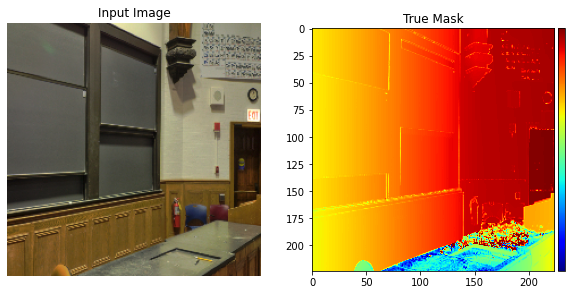

img Min and max pixel values: 0.0 255.0
img Min and max label values: 0.8155322 2.1649954


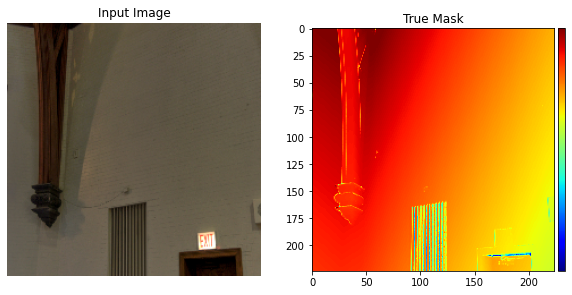

img Min and max pixel values: 5.076513 255.0
img Min and max label values: 0.7959536 2.12083


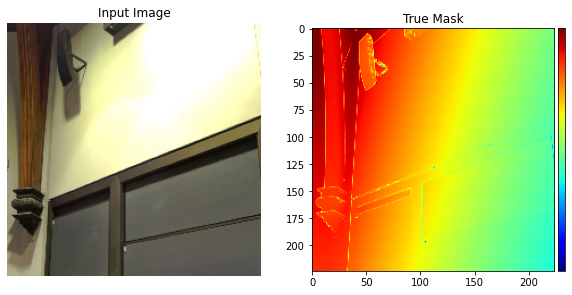

img Min and max pixel values: 0.0 255.0
img Min and max label values: 0.1 1.2848767


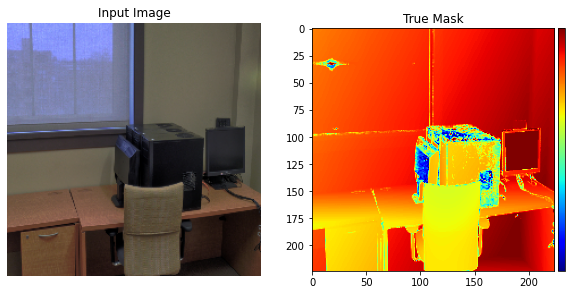

img Min and max pixel values: 29.234697 255.0
img Min and max label values: 0.1 0.9284392


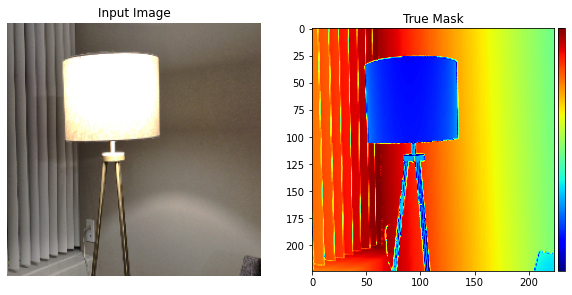

img Min and max pixel values: 8.729452 255.0
img Min and max label values: 0.1 1.8275034


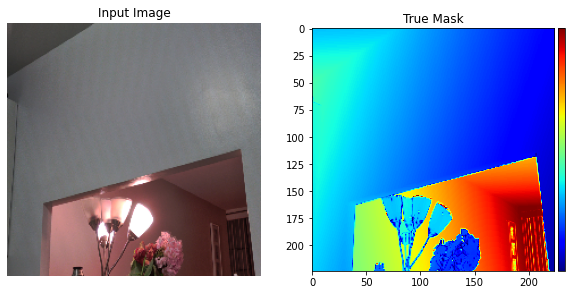

In [88]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def display_sample(display_list):
  """Show side-by-side an input image,
  the ground truth and the prediction.
  """
  fig = plt.figure(figsize=(10, 10))
  cmap = plt.cm.jet
  cmap.set_bad(color="black")

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    ax = plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i==0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    else:
      im = plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap=cmap)
      
      # create an axes on the right side of ax. The width of cax will be 5%
      # of ax and the padding between cax and ax will be fixed at 0.05 inch.
      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="3%", pad=0.05)
      if i==1:
        v = np.linspace(0.1, display_list[i].numpy().max(), 15, endpoint=True)
      else:
        v = np.linspace(0.1, display_list[i].max(), 15, endpoint=True)

      plt.colorbar(im, cax=cax, ticks=v)
      
    plt.axis('off')
  plt.show()

for image, mask in train_batches.take(6):
  sample_image, sample_mask = image, mask

  img, label = sample_image[0].numpy(), sample_mask[0].numpy() 
  print("img Min and max pixel values:", img.min(), img.max())
  print("img Min and max label values:", label.min(), label.max())
  
  display_sample([sample_image[0], sample_mask[0]])

## 3D point cloud visualization

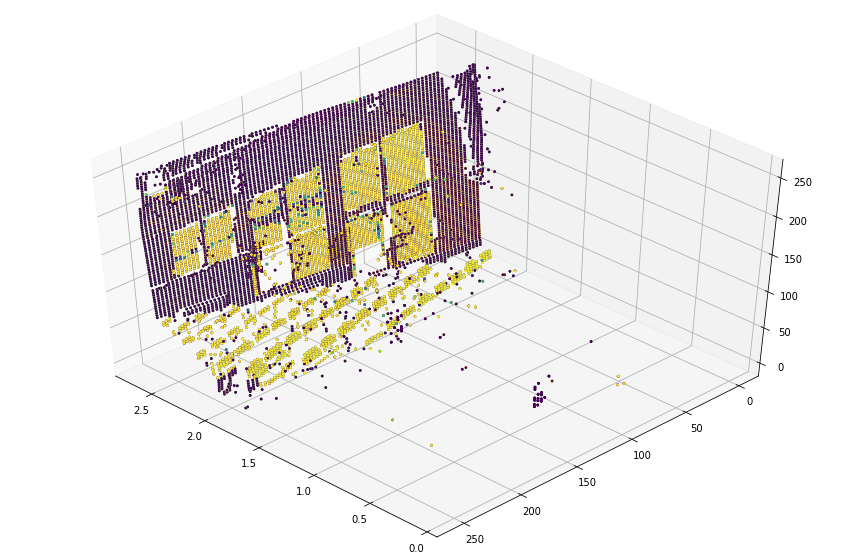

In [ ]:
depth_vis = np.flipud(visualize_samples[1][1].squeeze())  # target
img_vis = np.flipud(visualize_samples[0][1].squeeze())  # input

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")

STEP = 3
for x in range(0, img_vis.shape[0], STEP):
    for y in range(0, img_vis.shape[1], STEP):
        ax.scatter(
            [depth_vis[x, y]] * 3,
            [y] * 3,
            [x] * 3,
            c=tuple(img_vis[x, y, :3] / 255),
            s=3,
        )
    ax.view_init(45, 135)

## Building the model

The basic model is from [TransUnet](https://github.com/KenzaB27/TransUnet).


In [100]:
!pip install tensorflow-addons
!pip install validators
!pip install ml_collections

In [101]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import math
import ml_collections

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math
tfkc = tfk.callbacks

### Resnet V2

In [102]:
def ws_reg(kernel):
  kernel_mean, kernel_std = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
  kernel = (kernel - kernel_mean) / (kernel_std + 1e-5)

def conv3x3(cout, stride=1, groups=1, bias=False, name=""):
  return tfkl.Conv2D(cout, kernel_size=3, strides=stride, padding="same", use_bias=bias, groups=groups, name=name, kernel_regularizer=ws_reg)

def conv1x1(cout, stride=1, groups=1, bias=False, name=""):
  return tfkl.Conv2D(cout, kernel_size=1, strides=stride, padding="same", use_bias=bias, groups=groups, name=name, kernel_regularizer=ws_reg)

class PreActBottleneck(tfkl.Layer):
    """Pre-activation (v2) bottleneck block.
    """

    def __init__(self, cin, cout=None, cmid=None, stride=1, name="preact", **kwargs):
        super().__init__(name=name, **kwargs)
        cout = cout or cin
        cmid = cmid or cout//4

        self.gn1 = tfa.layers.GroupNormalization(
            32, epsilon=1e-6)  # TODO check axis
        self.conv1 = conv1x1(cmid, bias=False)
        self.gn2 = tfa.layers.GroupNormalization(32, epsilon=1e-6)
        # Original code has it on conv1!!
        self.conv2 = conv3x3(cmid, stride, bias=False)
        self.gn3 = tfa.layers.GroupNormalization(32, epsilon=1e-6)
        self.conv3 = conv1x1(cout, bias=False)

        if (stride != 1 or cin != cout):
            # Projection also with pre-activation according to paper.
            self.downsample = conv1x1(cout, stride, bias=False)
            self.gn_proj = tfa.layers.GroupNormalization(cout, epsilon=1e-5)
    
    @tf.function(jit_compile = True)
    def call(self, x):

        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        # Unit's branch
        y = tf.nn.relu(self.gn1(self.conv1(x)))
        y = tf.nn.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = tf.nn.relu(residual + y)
        return y

    def load_from(self, weights, n_block, n_unit):
        conv1_weight = [weights[f"{n_block}/{n_unit}/conv1/kernel"]]
        conv2_weight = [weights[f"{n_block}/{n_unit}/conv2/kernel"]]
        conv3_weight = [weights[f"{n_block}/{n_unit}/conv3/kernel"]]

        gn1_weight = [np.squeeze(weights[f"{n_block}/{n_unit}/gn1/scale"], axis=(
            0, 1, 2)), np.squeeze(weights[f"{n_block}/{n_unit}/gn1/bias"], axis=(0, 1, 2))]
        gn2_weight = [np.squeeze(weights[f"{n_block}/{n_unit}/gn2/scale"], axis=(
            0, 1, 2)), np.squeeze(weights[f"{n_block}/{n_unit}/gn2/bias"], axis=(0, 1, 2))]
        gn3_weight = [np.squeeze(weights[f"{n_block}/{n_unit}/gn3/scale"], axis=(
            0, 1, 2)), np.squeeze(weights[f"{n_block}/{n_unit}/gn3/bias"], axis=(0, 1, 2))]

        self.conv1.set_weights(conv1_weight)
        self.conv2.set_weights(conv2_weight)
        self.conv3.set_weights(conv3_weight)

        self.gn1.set_weights(gn1_weight)
        self.gn2.set_weights(gn2_weight)
        self.gn3.set_weights(gn3_weight)

        if hasattr(self, 'downsample'):
            proj_conv_weight = [
                weights[f"{n_block}/{n_unit}/conv_proj/kernel"]]
            proj_gn_weight = [np.squeeze(weights[f"{n_block}/{n_unit}/gn_proj/scale"], axis=(
                0, 1, 2)), np.squeeze(weights[f"{n_block}/{n_unit}/gn_proj/bias"], axis=(0, 1, 2))]

            self.downsample.set_weights(proj_conv_weight)
            self.gn_proj.set_weights(proj_gn_weight)


class ResNetV2(tfk.Model):
    """Implementation of Pre-activation (v2) ResNet mode."""

    def __init__(self, block_units, width_factor=1, trainable=True, name="resnet_v2", **kwargs):
        super().__init__(trainable=trainable, name=name, **kwargs)
        self.block_units = block_units
        width = int(64 * width_factor)
        self.width = width

        self.root = tfk.Sequential([
            tfkl.Conv2D(width, kernel_size=7, strides=2,
                        use_bias=False, padding="same", name="conv", kernel_regularizer=ws_reg),
            tfa.layers.GroupNormalization(32, epsilon=1e-6),
            tfkl.ReLU()
        ])

        self.body = [
            tfk.Sequential(
                [PreActBottleneck(cin=width, cout=width*4, cmid=width, name="block1_unit1")] +
                [PreActBottleneck(cin=width*4, cout=width*4, cmid=width,
                                  name=f'block1_unit{i:d}') for i in range(2, block_units[0] + 1)]
            ),
            tfk.Sequential(
                [PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2, name="block2_unit1")] +
                [PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2,
                                  name=f'block2_unit{i:d}') for i in range(2, block_units[1] + 1)]
            ),
            tfk.Sequential(
                [PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2, name="block3_unit1")] +
                [PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4,
                                  name=f'block3_unit{i:d}') for i in range(2, block_units[2] + 1)]
            )
        ]
    
    @tf.function(jit_compile = True)
    def call(self, x):
        features = []
        in_size = x.shape[1]
        x = self.root(x)
        features.append(x)
        x = tfkl.MaxPool2D(pool_size=3, strides=2, padding="valid")(x)
        for i in range(len(self.body.layers)-1):
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i+1))
            b, h, w, c = x.shape
            if h != right_size:
                pad = right_size - h
                assert pad < 3 and pad > 0, "x {} should {}".format(
                    x.shape, right_size)
                feat = tfkl.ZeroPadding2D(padding=((0, pad), (0, pad)))(x)
            else:
                feat = x
            features.append(feat)
        x = self.body[-1](x)
        return x, features[::-1]

    def load_weights(self, res_weights):
        self.root.layers[0].set_weights([res_weights["conv_root/kernel"]])
        self.root.layers[1].set_weights([np.squeeze(res_weights["gn_root/scale"], axis=(
            0, 1, 2)), np.squeeze(res_weights["gn_root/bias"], axis=(0, 1, 2))])

        for i in range(len(self.block_units)):
            for j in range(self.block_units[i]):
                self.body.layers[i].layers[j].load_from(
                    res_weights, n_block=f"block{i+1}", n_unit=f"unit{j+1}")

### Encoding layer

In [103]:
class AddPositionEmbs(tfkl.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, trainable=True, **kwargs):
        super().__init__(trainable=trainable, **kwargs)
        self.trainable = trainable

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2])
            ),
            dtype="float32",
            trainable=self.trainable,
        )
    @tf.function(jit_compile = True)
    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)

class MultiHeadSelfAttention(tfkl.Layer):
    def __init__(self, *args, trainable=True, n_heads, **kwargs):
        super().__init__(trainable=trainable, *args, **kwargs)
        self.n_heads = n_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        n_heads = self.n_heads
        if hidden_size % n_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {n_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // n_heads
        self.query_dense = tfkl.Dense(
            hidden_size, name="query")
        self.key_dense = tfkl.Dense(
            hidden_size, name="key")
        self.value_dense = tfkl.Dense(
            hidden_size, name="value")
        self.combine_heads = tfkl.Dense(
            hidden_size, name="out")

    # pylint: disable=no-self-use
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.n_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    @tf.function(jit_compile = True)
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights

class TransformerBlock(tfkl.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, n_heads, mlp_dim, dropout, trainable=True, **kwargs):
        super().__init__(*args, trainable=trainable, **kwargs)
        self.n_heads = n_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            n_heads=self.n_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tfk.Sequential(
            [
                tfkl.Dense(
                    self.mlp_dim,
                    activation="linear",
                    name=f"{self.name}/Dense_0"
                ),
                tfkl.Lambda(
                    lambda x: tfk.activations.gelu(x, approximate=False)
                )
                if hasattr(tfk.activations, "gelu")
                else tfkl.Lambda(
                    lambda x: tfa.activations.gelu(x, approximate=False)
                ),
                tfkl.Dropout(self.dropout),
                tfkl.Dense(
                    input_shape[-1], name=f"{self.name}/Dense_1"),
                tfkl.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tfkl.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_0"
        )
        self.layernorm2 = tfkl.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_2"
        )
        self.dropout = tfkl.Dropout(self.dropout)
    
    @tf.function(jit_compile = True)
    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights

### Decoding layer

In [104]:
L2_WEIGHT_DECAY = 1e-4

class SegmentationHead(tfkl.Layer):
  
  def __init__(self, name="seg_head", filters=9, kernel_size=1, upsampling_factor=16, ** kwargs):
    super(SegmentationHead, self).__init__(name=name, **kwargs)
    self.filters = filters
    self.kernel_size = kernel_size
    self.upsampling_factor = upsampling_factor

  def build(self, input_shape):
    self.conv = tfkl.Conv2D(
        filters=self.filters, 
        kernel_size=self.kernel_size, 
        padding="same",
        kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY), 
        kernel_initializer=tfk.initializers.LecunNormal())
    
    self.upsampling = tfkl.UpSampling2D(
            size=self.upsampling_factor, interpolation="bilinear")
    
  @tf.function(jit_compile = True)
  def call(self, inputs):
    x = self.conv(inputs)
    if self.upsampling_factor > 1:
      x = self.upsampling(x)
    return x


class Conv2DReLu(tfkl.Layer):
  def __init__(self, filters, kernel_size, padding="same", strides=1, **kwargs):
    super().__init__(**kwargs)
    self.filters = filters
    self.kernel_size = kernel_size
    self.padding = padding
    self.strides = strides

  def build(self, input_shape):
    self.conv = tfkl.Conv2D(
        filters=self.filters, kernel_size=self.kernel_size, strides=self.strides,
        padding=self.padding, use_bias=False, kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY), 
        kernel_initializer="lecun_normal")

    self.bn = tfkl.BatchNormalization(momentum=0.9, epsilon=1e-5)
    
  @tf.function(jit_compile = True)
  def call(self, inputs):
    x = self.conv(inputs)
    x = self.bn(x)
    x = tf.nn.relu(x)
    return x


class DecoderBlock(tfkl.Layer):
  def __init__(self, filters, **kwargs):
    super().__init__(**kwargs)
    self.filters = filters

  def build(self, input_shape):
    self.conv1 = Conv2DReLu(filters=self.filters, kernel_size=1) #3
    self.conv2 = Conv2DReLu(filters=self.filters, kernel_size=1) #3
    self.upsampling = tfkl.UpSampling2D(size=2, interpolation="bilinear")
    
  @tf.function()
  def call(self, inputs, skip=None):    
    with tf.xla.experimental.jit_scope(compile_ops=False):
      x = self.upsampling(inputs)

    with tf.xla.experimental.jit_scope():
      if skip is not None: x = tf.concat([x, skip], axis=-1)
      x = self.conv1(x)
      x = self.conv2(x)
    
    return x


class DecoderCup(tfkl.Layer):
  def __init__(self, decoder_channels, n_skip=3, **kwargs):
    super().__init__(**kwargs)
    self.decoder_channels = decoder_channels
    self.n_skip = n_skip

  def build(self, input_shape):
    self.conv_more = Conv2DReLu(filters=512, kernel_size=1) #3
    self.blocks = [DecoderBlock(filters=out_ch) for out_ch in self.decoder_channels]
    
  @tf.function()
  def call(self, hidden_states, features):
    x = self.conv_more(hidden_states)
    for i, decoder_block in enumerate(self.blocks):
      if features is not None:
        skip = features[i] if (i < self.n_skip) else None
      else:
        skip = None
      x = decoder_block(x, skip=skip)
    return x

### Utils

In [105]:
import os
import typing
import warnings
from urllib import request
from http import client
import io
import pkg_resources
import validators
import numpy as np
import scipy as sp
import cv2

try:
    import PIL
    import PIL.Image
except ImportError:  # pragma: no cover
    PIL = None

ImageInputType = typing.Union[str, np.ndarray, "PIL.Image.Image", io.BytesIO]


def get_imagenet_classes() -> typing.List[str]:
    """Get the list of ImageNet 2012 classes."""
    filepath = pkg_resources.resource_filename("vit_keras", "imagenet2012.txt")
    with open(filepath) as f:
        classes = [l.strip() for l in f.readlines()]
    return classes


def read(filepath_or_buffer: ImageInputType, size, timeout=None):
    """Read a file into an image object
    Args:
        filepath_or_buffer: The path to the file or any object
            with a `read` method (such as `io.BytesIO`)
        size: The size to resize the image to.
        timeout: If filepath_or_buffer is a URL, the timeout to
            use for making the HTTP request.
    """
    if PIL is not None and isinstance(filepath_or_buffer, PIL.Image.Image):
        return np.array(filepath_or_buffer.convert("RGB"))
    if isinstance(filepath_or_buffer, (io.BytesIO, client.HTTPResponse)):
        image = np.asarray(
            bytearray(filepath_or_buffer.read()), dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
    elif isinstance(filepath_or_buffer, str) and validators.url(filepath_or_buffer):
        return read(request.urlopen(filepath_or_buffer, timeout=timeout), size=size)
    else:
        if not os.path.isfile(filepath_or_buffer):
            raise FileNotFoundError(
                "Could not find image at path: " + filepath_or_buffer
            )
        image = cv2.imread(filepath_or_buffer)
    if image is None:
        raise ValueError(f"An error occurred reading {filepath_or_buffer}.")
    # We use cvtColor here instead of just ret[..., ::-1]
    # in order to ensure that we provide a contiguous
    # array for later processing. Some hashers use ctypes
    # to pass the array and non-contiguous arrays can lead
    # to erroneous results.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(image, (size, size))


def apply_embedding_weights(target_layer, source_weights):
    """Apply embedding weights to a target layer.
    Args:
        target_layer: The target layer to which weights will
            be applied.
        source_weights: The source weights, which will be
            resized as necessary.
    """
    expected_shape = target_layer.weights[0].shape
    if expected_shape ==  source_weights.shape:
        grid = source_weights
    elif expected_shape[1] == source_weights.shape[1]-1:
        grid = source_weights[:, 1:]
    else:
        _, grid = source_weights[0, :1], source_weights[0, 1:]
        sin = int(np.sqrt(grid.shape[0]))
        sout = int(np.sqrt(expected_shape[1]))
        warnings.warn(
            "Resizing position embeddings from " f"{sin} to {sout}",
            UserWarning,
        )
        zoom = (sout / sin, sout / sin, 1)
        grid = sp.ndimage.zoom(grid.reshape(sin, sin, -1), zoom, order=1).reshape(
            1, sout * sout, -1)
    target_layer.set_weights([grid])


def load_weights_numpy(model, params_path):
    """Load weights saved using Flax as a numpy array.
    Args:
        model: A Keras model to load the weights into.
        params_path: Filepath to a numpy archive.
    """
    params_dict = np.load(
        params_path, allow_pickle=False
    )  # pylint: disable=unexpected-keyword-arg
    source_keys = list(params_dict.keys())
    
    source_keys_used = []
    n_transformers = len(
        set(
            "/".join(k.split("/")[:2])
            for k in source_keys
            if k.startswith("Transformer/encoderblock_")
        )
    )
    n_transformers_out = sum(
        l.name.startswith("Transformer/encoderblock_") for l in model.layers
    )
    assert n_transformers == n_transformers_out, (
        f"Wrong number of transformers ("
        f"{n_transformers_out} in model vs. {n_transformers} in weights)."
    )

    matches = []
    for tidx in range(n_transformers):
        encoder = model.get_layer(f"Transformer/encoderblock_{tidx}")
        source_prefix = f"Transformer/encoderblock_{tidx}"
        matches.extend(
            [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/{norm}/{name}" for name in ["scale", "bias"]
                    ],
                }
                for norm, layer in [
                    ("LayerNorm_0", encoder.layernorm1),
                    ("LayerNorm_2", encoder.layernorm2),
                ]
            ]
            + [
                {
                    "layer": encoder.mlpblock.get_layer(
                        f"{source_prefix}/Dense_{mlpdense}"
                    ),
                    "keys": [
                        f"{source_prefix}/MlpBlock_3/Dense_{mlpdense}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                }
                for mlpdense in [0, 1]
            ]
            + [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/MultiHeadDotProductAttention_1/{attvar}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                    "reshape": True,
                }
                for attvar, layer in [
                    ("query", encoder.att.query_dense),
                    ("key", encoder.att.key_dense),
                    ("value", encoder.att.value_dense),
                    ("out", encoder.att.combine_heads),
                ]
            ]
        )

    # Embedding kernel and bias
    matches.append(
        {
            "layer": model.get_layer("embedding"),
            "keys": [f"embedding/{name}" for name in ["kernel", "bias"]],
        }
    )

    matches.append(
        {
            "layer": model.get_layer("Transformer/encoder_norm"),
            "keys": [f"Transformer/encoder_norm/{name}" for name in ["scale", "bias"]],
        }
    )
    apply_embedding_weights(
        target_layer=model.get_layer("Transformer/posembed_input"),
        source_weights=params_dict["Transformer/posembed_input/pos_embedding"],
    )
    source_keys_used.append("Transformer/posembed_input/pos_embedding")
    for match in matches:
        source_keys_used.extend(match["keys"])
        source_weights = [params_dict[k] for k in match["keys"]]
        if match.get("reshape", False):
            source_weights = [
                source.reshape(expected.shape)
                for source, expected in zip(
                    source_weights, match["layer"].weights #TF 2.0 match["layer"].get_weights()
                )
            ]
        match["layer"].set_weights(source_weights)

### TransUnet

We will optimize 3 losses in our mode.
1. Structural similarity index(SSIM).
2. L1-loss, or Point-wise depth in our case.
3. Depth smoothness loss.

Out of the three loss functions, SSIM contributes the most to improving model performance.

In [106]:
MODELS_URL = 'https://storage.googleapis.com/vit_models/imagenet21k/'
loss_metric = tf.keras.metrics.Mean(name="loss")
#N_CLASSES = 9
#TRAINING_SAMPLES = 2211

class TransUnet():

  def __init__(self, config, trainable=True):
    self.config = config
    self.image_size = config.image_size
    self.patch_size = config.patch_size
    self.n_layers = config.n_layers
    self.hidden_size = config.hidden_size
    self.n_heads = config.n_heads
    self.name = config.name
    self.mlp_dim = config.mlp_dim
    self.dropout = config.dropout
    self.filters = config.filters
    self.kernel_size = config.kernel_size
    self.upsampling_factor = config.upsampling_factor
    self.hybrid = config.hybrid
    
    self.trainable = trainable
    self.epochs = EPOCHS
    self.batch_size = BATCH_SIZE
    self.model = self.build_model()
 
  class DepthEstimationModel(tfk.Model):
    #https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    
    def train_step(self, batch_data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      input, target = batch_data
      with tf.GradientTape() as tape:
        # Forward pass
        pred = self(input, training=True)
        # Compute the loss value
        # (the loss function is configured in `compile()`)
        loss = self.compiled_loss(target, pred, regularization_losses=self.losses)
      
      # Compute gradients
      gradients = tape.gradient(loss, self.trainable_variables)
      # Update weights
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
      # Update metrics (includes the metric that tracks the loss)
      loss_metric.update_state(loss)
      # Return a dict mapping metric names to current value
      return {"loss": loss_metric.result(),}

    def test_step(self, batch_data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      input, target = batch_data
      # Forward pass
      pred = self(input, training=False)
      # Compute the loss value
      # (the loss function is configured in `compile()`)
      loss = self.compiled_loss(target, pred, regularization_losses=self.losses)
      # Update metrics (includes the metric that tracks the loss)
      loss_metric.update_state(loss)
      # Return a dict mapping metric names to current value
      return {"loss": loss_metric.result(),}

  def build_model(self):
    
    # Tranformer Encoder
    assert self.image_size % self.patch_size == 0, "image_size must be a multiple of patch_size"
    x = tf.keras.layers.Input(shape=(self.image_size, self.image_size, 3))

    # Embedding
    if self.hybrid:
      grid_size = self.config.grid
      self.patch_size = self.image_size // 16 // grid_size[0]
      
      if self.patch_size == 0: self.patch_size = 1
            
      if self.trainable:
        self.resnet50v2 = ResNetV2(block_units=self.config.resnet.n_layers)
        y, features = self.resnet50v2(x)
      else:
        resnet50v2, features = self.resnet_embeddings(x)
        y = resnet50v2.get_layer("conv4_block6_preact_relu").output
        x = resnet50v2.input
    else:
      y = x
      features = None

    y = tfkl.Conv2D(
        filters=self.hidden_size,
        kernel_size=self.patch_size,
        strides=self.patch_size,
        padding="valid",
        name="embedding",
        trainable=self.trainable)(y)
        
    y = tfkl.Reshape((y.shape[1] * y.shape[2], self.hidden_size))(y)
    y = AddPositionEmbs(name="Transformer/posembed_input", trainable=self.trainable)(y)

    y = tfkl.Dropout(0.1)(y)

    # Transformer/Encoder
    for n in range(self.n_layers):
      y, _ = TransformerBlock(
          n_heads=self.n_heads,
          mlp_dim=self.mlp_dim,
          dropout=self.dropout,
          name=f"Transformer/encoderblock_{n}",
          trainable=self.trainable)(y)
    
    y = tfkl.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(y)

    n_patch_sqrt = int(math.sqrt(y.shape[1]))

    y = tfkl.Reshape(target_shape=[n_patch_sqrt, n_patch_sqrt, self.hidden_size])(y)

    # Decoder CUP
    if "decoder_channels" in self.config:
      y = DecoderCup(decoder_channels=self.config.decoder_channels, n_skip=self.config.n_skip)(y, features)

    # Segmentation Head
    y = SegmentationHead(filters=self.filters, kernel_size=self.kernel_size, upsampling_factor=self.upsampling_factor)(y)
    
    # Activation tanh
    #y = tfkl.Activation(tfk.activations.tanh)(y)
    
    return self.DepthEstimationModel(x, y)   #tfk.models.Model(inputs=x, outputs=y, name=self.name)

  def load_pretrained(self):
    """Load model weights for a known configuration."""
    origin = MODELS_URL + self.config.pretrained_filename
    fname = self.config.pretrained_filename
    local_filepath = tf.keras.utils.get_file(fname, origin, cache_subdir="weights")

    load_weights_numpy(self.model, local_filepath)
 
  def compile(self, lr=None, cyclic_lr=False):
    
    self.load_pretrained()
  
    steps_per_epoch = (lengt_dataset-val_ds_size) // self.batch_size
    
    if lr is None and not cyclic_lr:
      starter_learning_rate = 0.0002
      end_learning_rate = 0
      decay_steps = self.epochs * steps_per_epoch
      lr = tf.keras.optimizers.schedules.PolynomialDecay(
          starter_learning_rate,
          decay_steps,
          end_learning_rate,
          power=0.9)
      
    elif cyclic_lr:
      cycles_n = 25
      step_size = self.epochs * steps_per_epoch / (cycles_n*2)
      lr = tfa.optimizers.CyclicalLearningRate(
          initial_learning_rate=1e-5,
          maximal_learning_rate=1e-2,
          step_size=step_size,
          scale_fn=lambda x: 1.0)
      
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    self.model.compile(optimizer=optimizer, loss=[TransUnet.depthestimation_loss])
    
  def train_validate(self, training_dataset, validation_dataset, save_path, show_history=True):
    
    checkpoint_filepath = save_path + '/checkpoint/'
    model_checkpoint_callback = tfkc.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

    steps_per_epoch = (lengt_dataset-val_ds_size) // self.batch_size
    validation_steps_per_epoch = val_ds_size // self.batch_size
    history = self.model.fit(training_dataset, 
                            epochs=self.epochs, 
                            batch_size=self.batch_size, 
                            verbose=1,
                            steps_per_epoch=steps_per_epoch, 
                            validation_data=validation_dataset,
                            validation_steps= validation_steps_per_epoch, 
                            callbacks=[model_checkpoint_callback])

    self.model.load_weights(checkpoint_filepath)

    saved_model_path = save_path + "/model"
    self.save_model(saved_model_path)

    print(f"Model saved in {saved_model_path}")

    if show_history:
      plt.figure()
      plt.plot(history.history["loss"], label="training loss")
      plt.plot(history.history["val_loss"], label="validation loss")
      plt.title(f"Loss for {self.name} model")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()

    return history

  def train(self, training_dataset, save_path, show_history=True):
        
    checkpoint_filepath = save_path + '/checkpoint/'
    model_checkpoint_callback = tfkc.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='loss',
            mode='min',
            save_best_only=True)

    steps_per_epoch = (lengt_dataset-val_ds_size) // self.batch_size
    history = self.model.fit(training_dataset, 
                            epochs=self.epochs, 
                            batch_size=self.batch_size, 
                            verbose=1,
                            steps_per_epoch=steps_per_epoch, 
                            callbacks=[model_checkpoint_callback])

    self.save_model(save_path + '/model')
    print(f"Model saved in {save_path}")
    if show_history:
      plt.figure()
      plt.plot(history.history["loss"], label="training loss")
      plt.title(f"Loss for {self.name} model")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()

    return history

  @tf.function
  def depthestimation_loss(y_true, y_pred, ssim_loss_weight = 0.85, l1_loss_weight = 0.1, edge_loss_weight = 0.9, maxDepthVal = WIDTH):
    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    edges_loss = tf.reduce_mean(tf.abs(dx_true-dx_pred)) + tf.reduce_mean(tf.abs(dy_true-dy_pred))

    # Depth smoothness
    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y
        
    depth_smoothness_loss = tf.reduce_mean(tf.abs(smoothness_x)) + tf.reduce_mean(tf.abs(smoothness_y))

    # Structural similarity (SSIM) index
    ssim_loss = tf.reduce_mean(1- tf.image.ssim(y_true, y_pred, max_val= maxDepthVal, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2)) 
    ssim_loss = tf.clip_by_value(ssim_loss,0,1)

    # Multi-scale Structural similarity (SSIM)
    #smoothness_SSIM =  tf.math.log(1 + tf.exp(-tf.image.ssim(target, pred, max_val= maxDepthVal)))
    msssim_loss = tf.reduce_mean(1- tf.image.ssim_multiscale(y_true, y_pred, max_val= maxDepthVal, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2)) 
    msssim_loss = tf.clip_by_value(msssim_loss,0,1)
            
    # Point-wise depth
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

    loss = ssim_loss_weight * (ssim_loss + 1/4*msssim_loss) + l1_loss_weight * l1_loss + edge_loss_weight * (depth_smoothness_loss + edges_loss)
                 
    return loss

  @tf.function
  def segmentation_loss(y_true, y_pred):
    cce = tfk.losses.CategoricalCrossentropy(from_logits=True)
    cross_entropy_loss = cce(y_true=y_true, y_pred=y_pred)
    dice_loss = TransUnet.gen_dice(y_true, y_pred)
    return 0.5 * cross_entropy_loss + 0.5 * dice_loss

  @tf.function
  def gen_dice(y_true, y_pred):
    """both tensors are [b, h, w, classes] and y_pred is in logit form"""
    # [b, h, w, classes]
    pred_tensor = tf.nn.softmax(y_pred)
    loss = 0.0
    for c in range(N_CLASSES):
      loss += TransUnet.dice_per_class(y_true[:, :, :, c], pred_tensor[:, :, :, c])
    return loss/N_CLASSES

  @tf.function
  def dice_per_class(y_true, y_pred, eps=1e-5):
    intersect = tf.reduce_sum(y_true * y_pred)
    y_sum = tf.reduce_sum(y_true * y_true)
    z_sum = tf.reduce_sum(y_pred * y_pred)
    loss = 1 - (2 * intersect + eps) / (z_sum + y_sum + eps)
    return loss

  def resnet_embeddings(self, x):
    resnet50v2 = tfk.applications.ResNet50V2(include_top=False,input_shape=(self.image_size,self.image_size,3))
    resnet50v2.trainable = False
    _ = resnet50v2(x)
    layers = ["conv3_block4_preact_relu",
              "conv2_block3_preact_relu",
              "conv1_conv"]

    features = []
    if self.config.n_skip > 0:
      for l in layers: features.append(resnet50v2.get_layer(l).output)
    return resnet50v2, features

  def save_model_tpu(self, saved_model_path):
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    self.model.save(saved_model_path, options=save_options)

  def save_model(self, saved_model_path):
    self.model.save(saved_model_path)

  def load_model(self, saved_model_path):
    model = tfk.models.load_model(saved_model_path, compile=False)
    self.model = model
    return model

  def load_model_tpu(self, tpu_strategy, saved_model_path):
    with tpu_strategy.scope():
      load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
      model = tfk.models.load_model(saved_model_path, options=load_options, compile=False)
      self.model = model
      return model

## Model training

### Config

In [107]:
def get_b16_none():
  """Returns the ViT-B/16 configuration."""
  config = ml_collections.ConfigDict()
  config.pretrained_filename = "ViT-B_16.npz"
  config.image_size = 224
  config.patch_size = 16
  config.n_layers = 12
  config.hidden_size = 768
  config.n_heads = 12
  config.name = "B16_None"
  config.mlp_dim = 3072
  config.dropout = 0.1
  config.filters = 1 #9
  config.kernel_size = 1
  config.upsampling_factor = 16
  config.hybrid = False
  return config


def get_b16_cup():
  """Returns the ViT-B/16 configuration."""
  config = get_b16_none()
  config.name = "B16_CUP"
  config.upsampling_factor = 1
  config.decoder_channels = [256, 128, 64, 16]
  config.n_skip = 0
  return config


def get_r50_b16():
  """Returns the Resnet50 + ViT-B/16 configuration."""
  config = get_b16_cup()
  config.image_size = 224
  config.name = "R50-B16_CUP"
  config.pretrained_filename = "R50+ViT-B_16.npz"
  config.decoder_channels = [256, 128, 64, 16]
  config.n_skip = 0
  config.hybrid = True
  config.grid = (14, 14)
  config.resnet = ml_collections.ConfigDict()
  config.resnet.n_layers = (3,4,9)
  config.resnet.width_factor = 1
  return config


def get_transunet():
  """Returns the Resnet50 + ViT-B/16 configuration."""
  config = get_r50_b16()
  config.name = "TransUNet"
  config.n_skip = 3
  return config

### Training

In [108]:
config = get_transunet()
model = TransUnet(config)
model.compile()

Epoch 1/150
32/32 [==============================] - 99s 943ms/step - loss: 1.1538 - val_loss: 1.0877
Epoch 2/150
32/32 [==============================] - 55s 409ms/step - loss: 0.9304 - val_loss: 0.8960
Epoch 3/150
32/32 [==============================] - 28s 903ms/step - loss: 0.8165 - val_loss: 0.7944
Epoch 4/150
32/32 [==============================] - 13s 399ms/step - loss: 0.7429 - val_loss: 0.7276
Epoch 5/150
32/32 [==============================] - 13s 400ms/step - loss: 0.6963 - val_loss: 0.6849
Epoch 6/150
32/32 [==============================] - 13s 401ms/step - loss: 0.6624 - val_loss: 0.6536
Epoch 7/150
32/32 [==============================] - 13s 400ms/step - loss: 0.6369 - val_loss: 0.6299
Epoch 8/150
32/32 [==============================] - 13s 400ms/step - loss: 0.6170 - val_loss: 0.6112
Epoch 9/150
32/32 [==============================] - 13s 402ms/step - loss: 0.6026 - val_loss: 0.5977
Epoch 10/150
32/32 [==============================] - 13s 400ms/step - loss: 0.589

INFO:tensorflow:Assets written to: ./content//model/assets


INFO:tensorflow:Assets written to: ./content//model/assets


Model saved in ./content//model


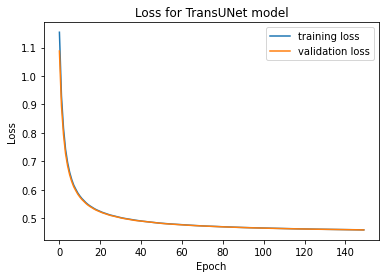

In [109]:
model.train_validate(train_batches, val_batches, "./content/")

## Visualizing model output

We visualize the model output over the validation set.
The first image is the RGB image, the second image is the ground truth depth map image
and the third one is the predicted depth map image.

img Min and max pixel values: 0.0 252.08676
img Min and max label values: 0.1 0.8958108


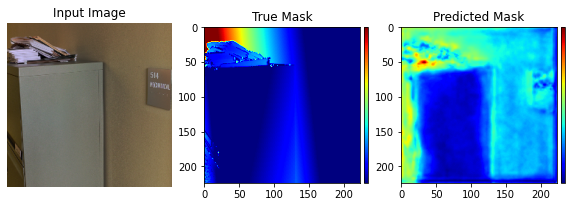

img Min and max pixel values: 0.0 255.0
img Min and max label values: 0.118097275 2.399119


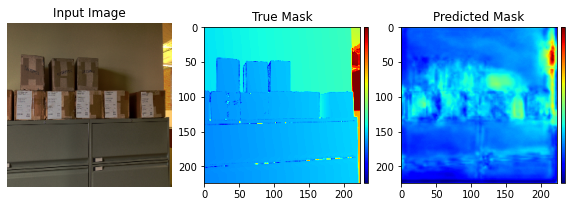

img Min and max pixel values: 0.0 221.88744
img Min and max label values: 0.10969191 1.0309067


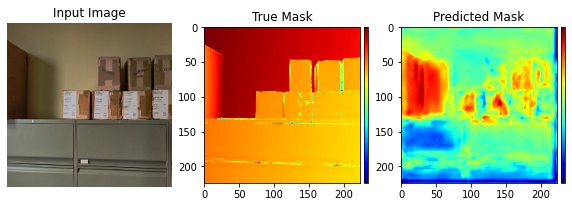

img Min and max pixel values: 0.0 219.82214
img Min and max label values: 0.3839226 1.2266427


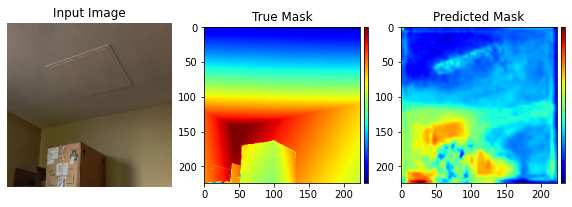

img Min and max pixel values: 0.0 212.745
img Min and max label values: 0.1 1.7962974


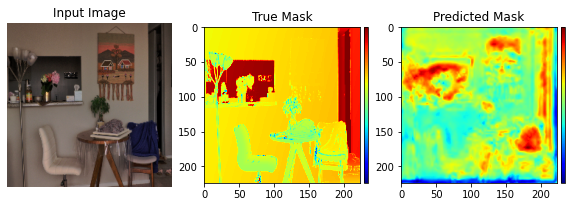

img Min and max pixel values: 0.0 154.9487
img Min and max label values: 0.3261299 1.8091413


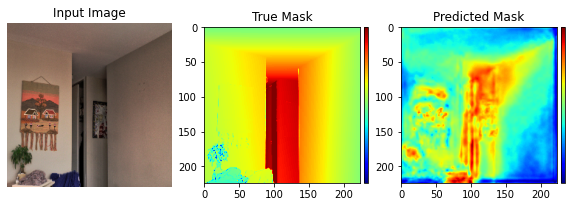

img Min and max pixel values: 26.80613 255.0
img Min and max label values: 0.1 0.7846542


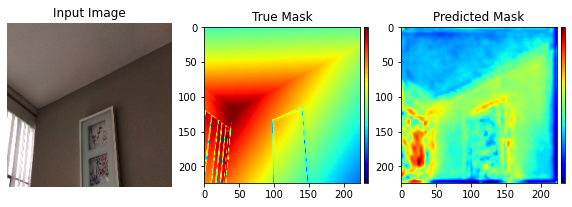

img Min and max pixel values: 0.0 255.0
img Min and max label values: 0.1 2.436648


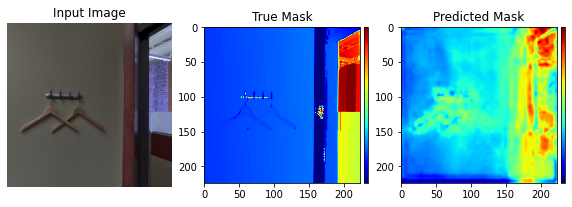

img Min and max pixel values: 0.0 192.28583
img Min and max label values: 0.1 0.9031591


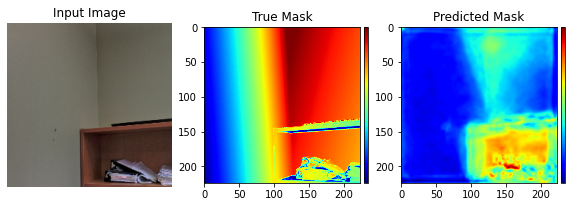

In [110]:
trained_model = model.load_model("./content/model/")
for image, mask in val_batches.take(12):
  sample_image, sample_mask = image, mask
  pred = trained_model.predict(sample_image)

  img, label = sample_image[0].numpy(), sample_mask[0].numpy() 
  print("img Min and max pixel values:", img.min(), img.max())
  print("img Min and max label values:", label.min(), label.max())
  
  display_sample([sample_image[0], sample_mask[0], pred[0]])

## Possible improvements

1. You can improve this model by replacing the encoding part of the U-Net with a
pretrained DenseNet or ResNet.
2. Loss functions play an important role in solving this problem.
Tuning the loss functions may yield significant improvement.

## References

The following papers go deeper into possible approaches for depth estimation.
1. [Depth Prediction Without the Sensors: Leveraging Structure for Unsupervised Learning from Monocular Videos](https://arxiv.org/pdf/1811.06152v1.pdf)
2. [Digging Into Self-Supervised Monocular Depth Estimation](https://openaccess.thecvf.com/content_ICCV_2019/papers/Godard_Digging_Into_Self-Supervised_Monocular_Depth_Estimation_ICCV_2019_paper.pdf)
3. [Deeper Depth Prediction with Fully Convolutional Residual Networks](https://arxiv.org/pdf/1606.00373v2.pdf)

You can also find helpful implementations in the papers with code depth estimation task.